# Creating Figures Strong Corr

## Creating Panel B

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.calculation import get_response_bg_firing
from lib.figure_5 import fig_5_panel_b

mono_pairs = get_dms_pfc_paths_mono()

for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['dms_path'])

    session_name = basename(row['session_path']).split('.')[0]
    pfc_name = basename(row['pfc_path']).split('.')[0]
    str_name = basename(row['dms_path']).split('.')[0]
    fig_name = '_'.join([session_name, pfc_name, str_name, 'iti']) + '.png'
    fig_path = pjoin('figures', 'figure_5', 'panel_b', fig_name)

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    fig = fig_5_panel_b(pfc_mag, str_mag)
    fig.savefig(fig_path, dpi=300)
    plt.close()

## Panel C Mono

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_response_bg_firing

mono_pairs = get_dms_pfc_paths_mono()

phase_diffs = []
phase_diffs_bg = [] 
for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['str_path'])

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=str_mag, dms_bg=str_bg)
    phase_diffs.append(phase_d)
    phase_diffs_bg.append(phase_d_bg)

fig_path = pjoin('figures', 'figure_5', 'panel_c', 'mono_all.jpg')
fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36)
fig.savefig(fig_path, dpi=300)

## Panel D Mono

In [ ]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=True, bin_size=36, zero_ymin=True)

## Panel C All

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir

from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_session_performances, get_response_bg_firing

phase_diffs = []
phase_diffs_bg = [] 
bin_size = 100

performances, cutoff = get_session_performances()
spike_data_root = pjoin('data', 'spike_times', 'sessions')
behaviour_root = pjoin('data', 'behaviour_data')

for session_name in listdir(spike_data_root):
    behaviour = pjoin(behaviour_root, session_name + '.csv')
    behaviour_data = pd.read_csv(behaviour)
    cue_times = behaviour_data['cue_time'].tolist()
    for pfc in glob(pjoin(spike_data_root, session_name, 'pfc_*')):
        pfc_times = np.load(pfc)
        for dms in glob(pjoin(spike_data_root, session_name, 'str_*')):
            str_times = np.load(dms)
            pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
            dms_mag, dms_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)
            phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=dms_mag, dms_bg=dms_bg)
            phase_diffs.append(phase_d)
            phase_diffs_bg.append(phase_d_bg)

fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36, zero_ymin=False)

## Panel D All

100%|██████████| 29/29 [02:06<00:00,  4.38s/it]


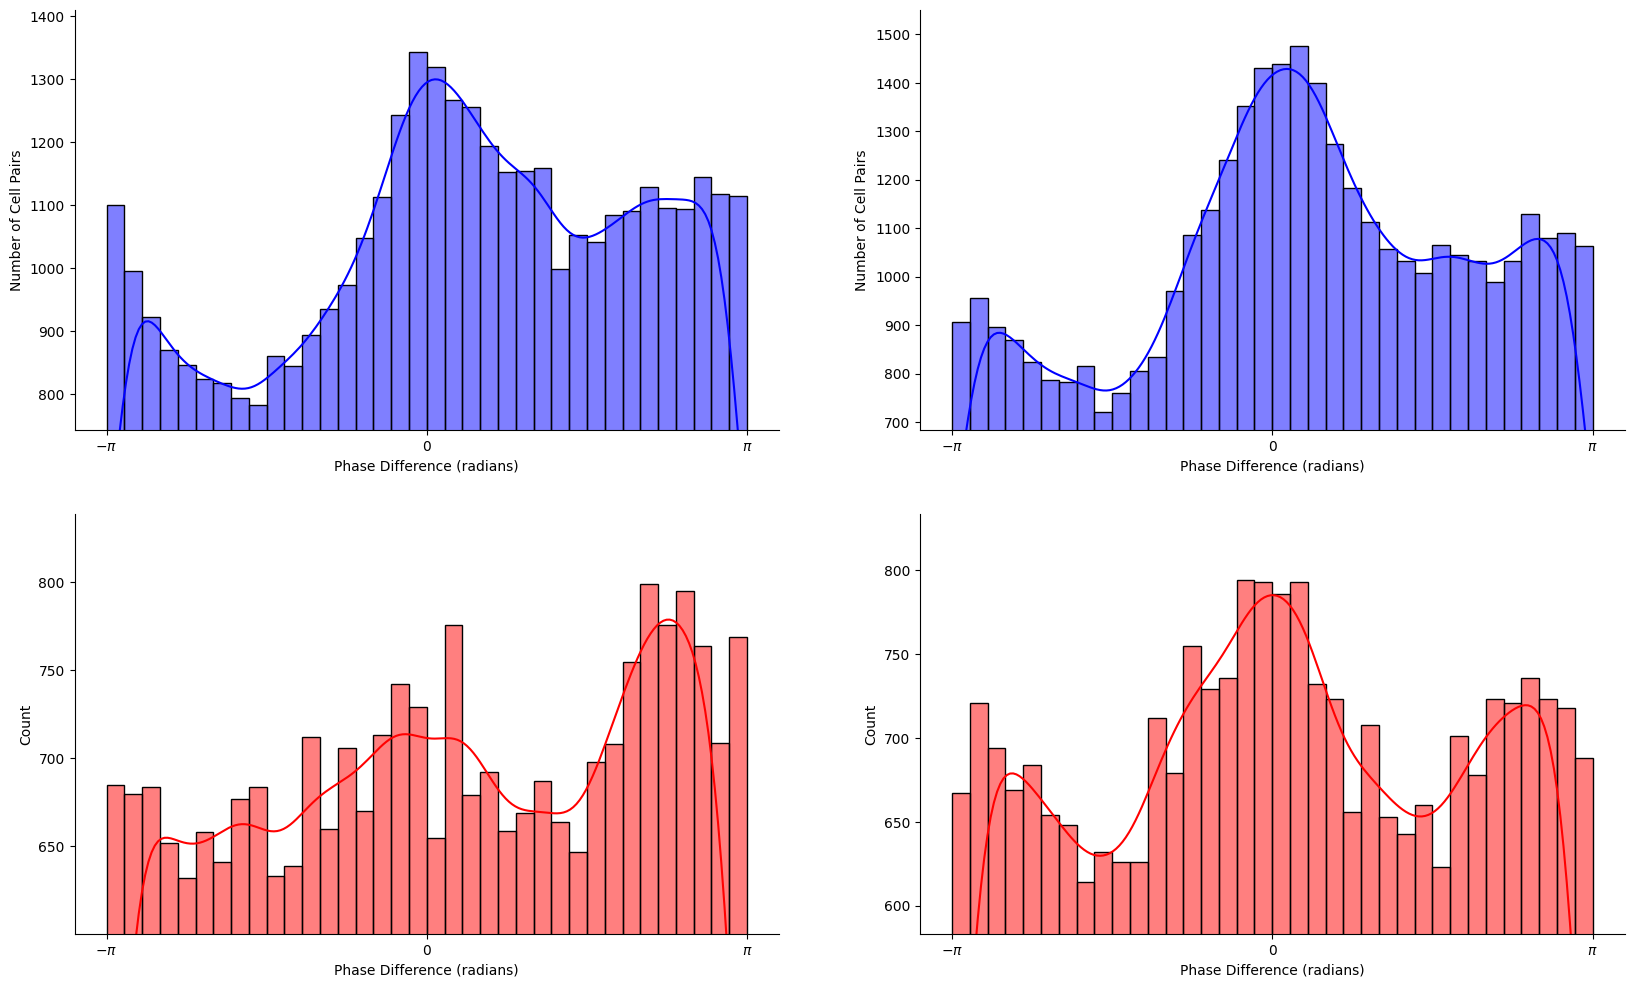

In [1]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=False, bin_size=36, zero_ymin=False)

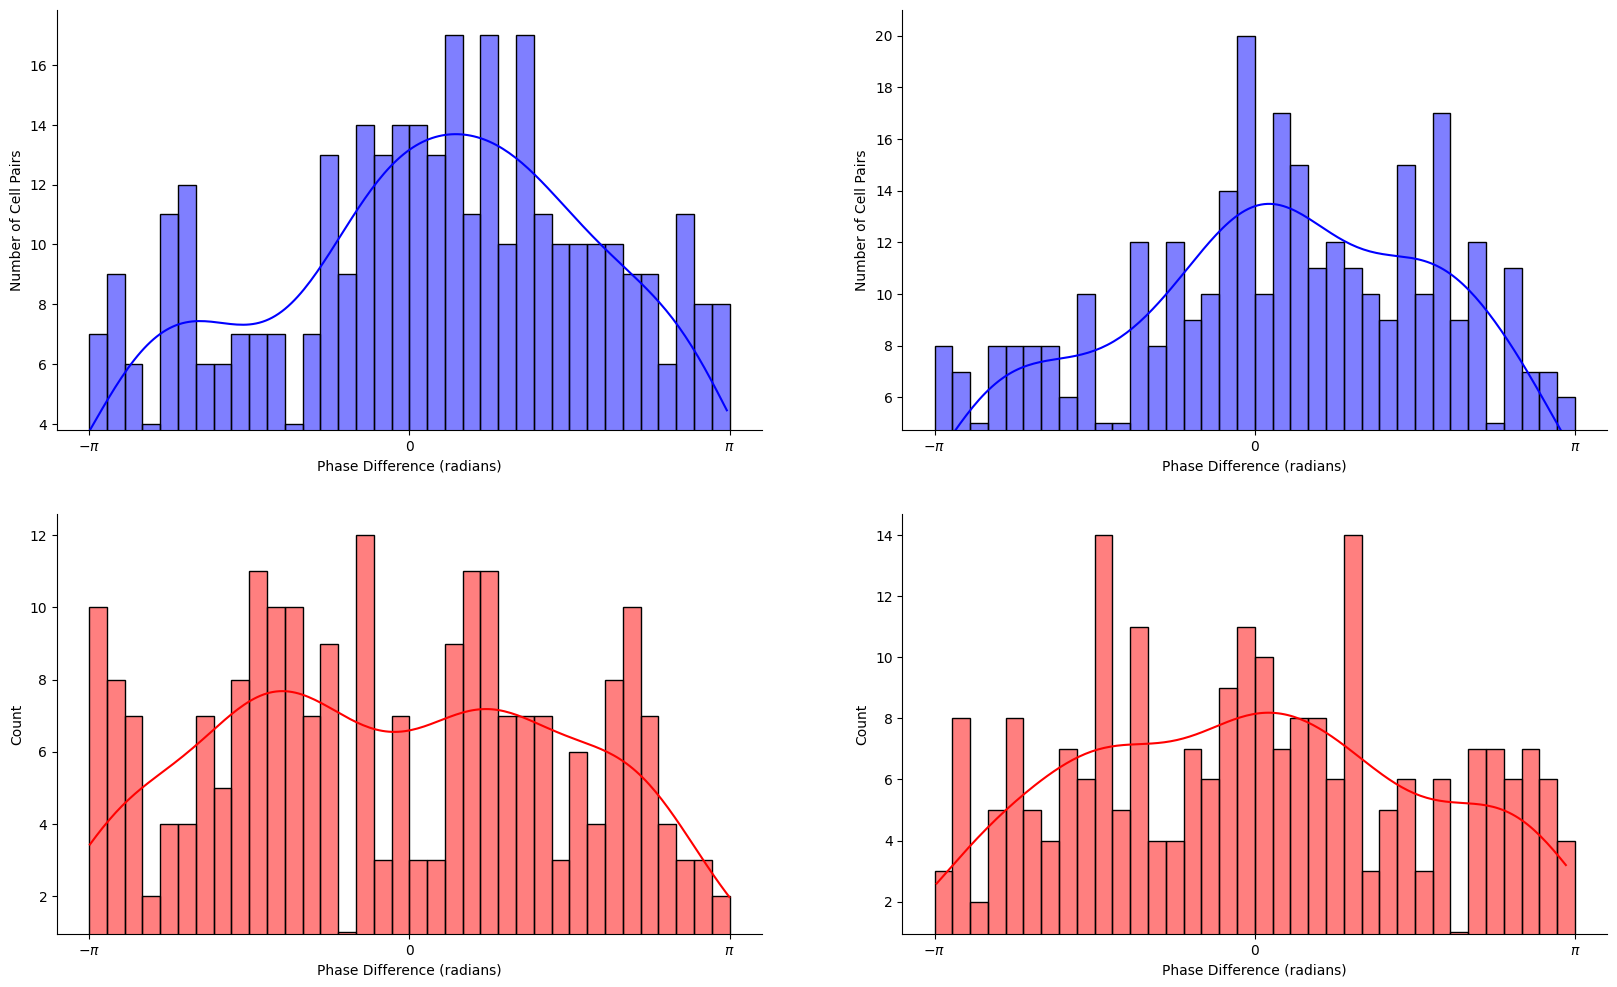

In [5]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=True, bin_size=36, zero_ymin=False)

## Check relative value and PRPD correlation

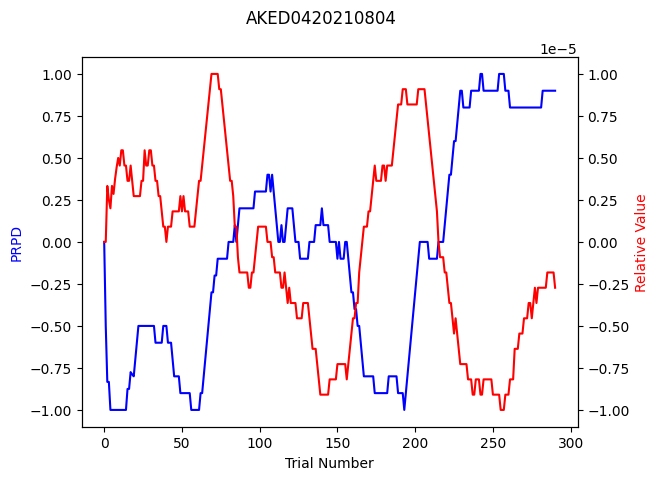

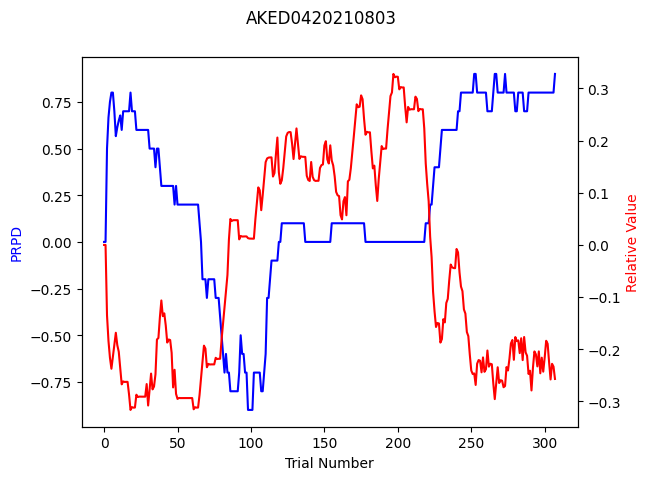

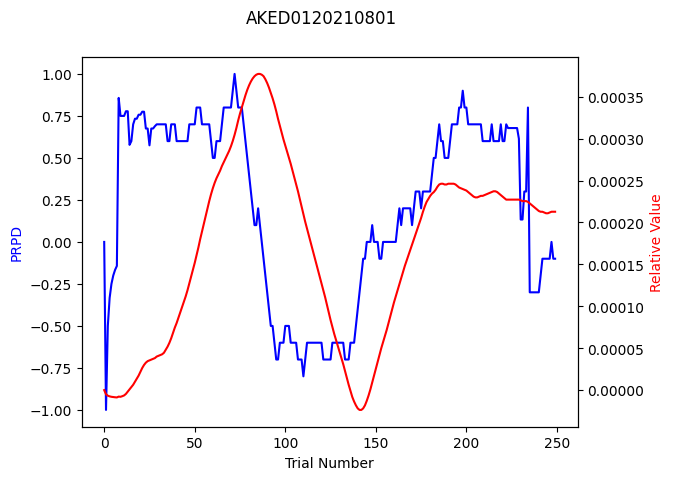

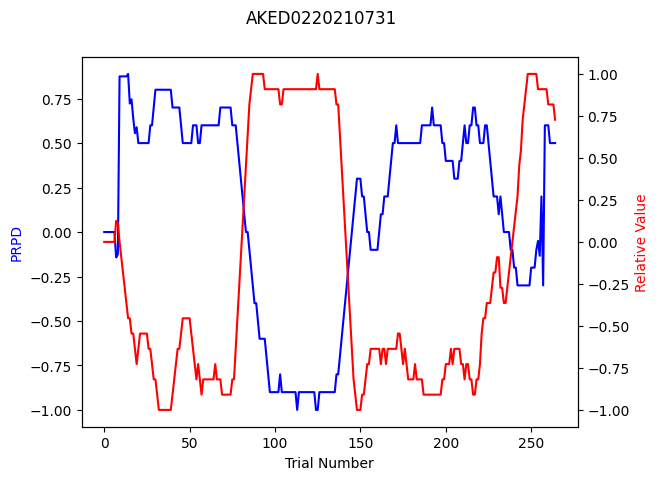

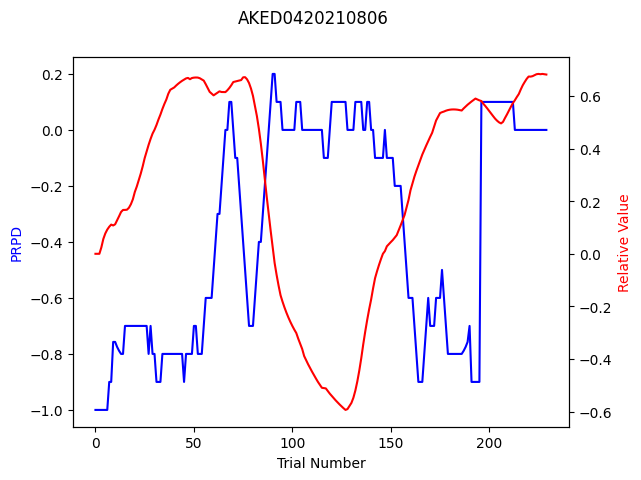

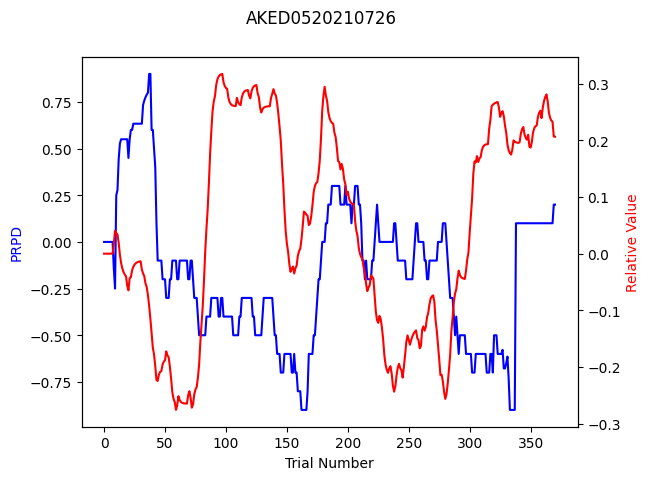

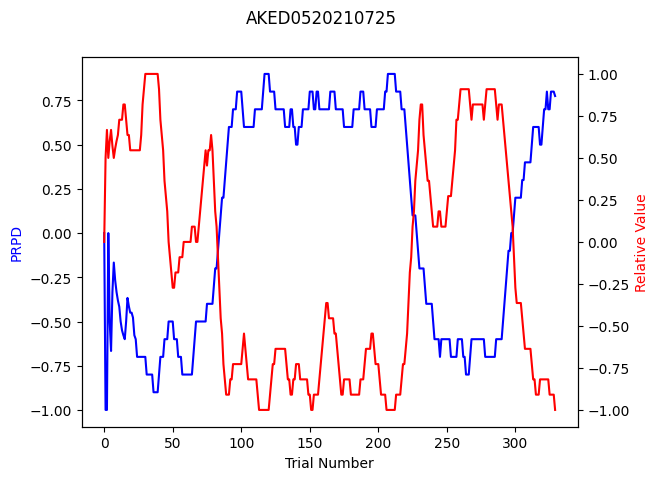

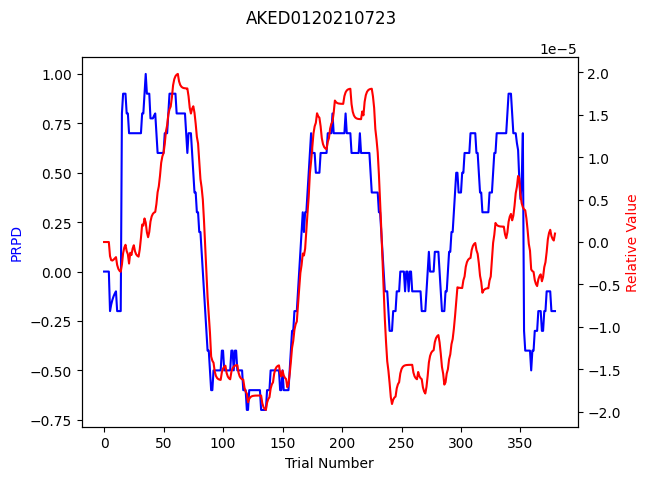

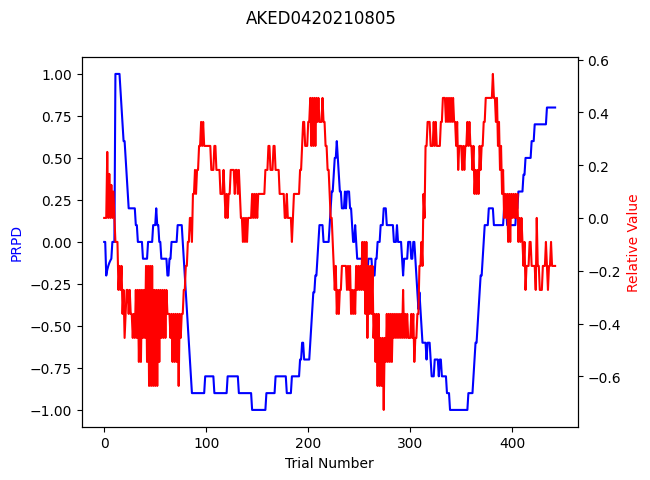

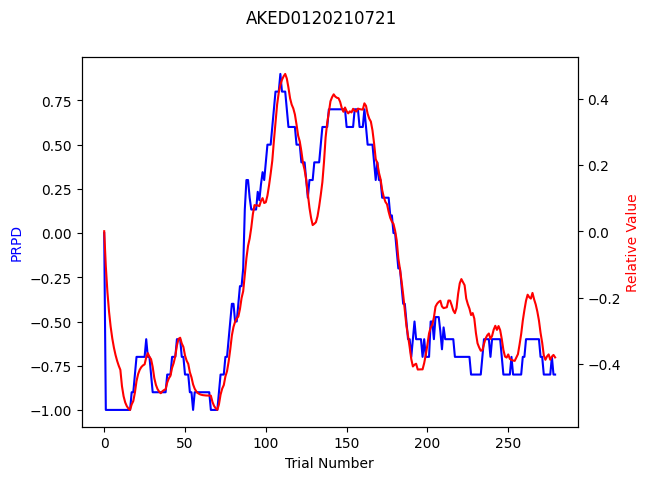

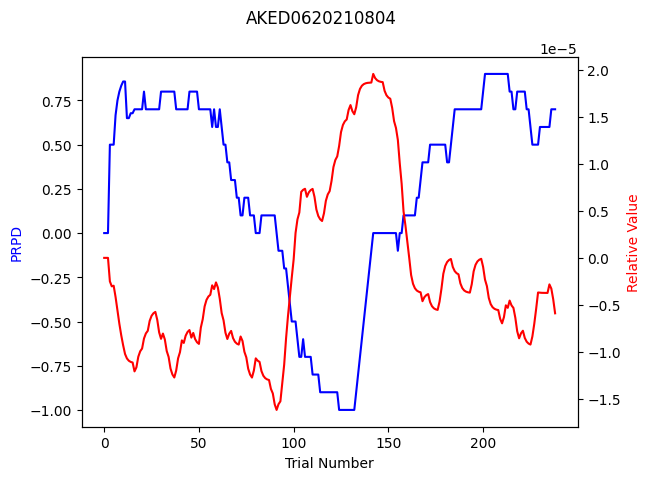

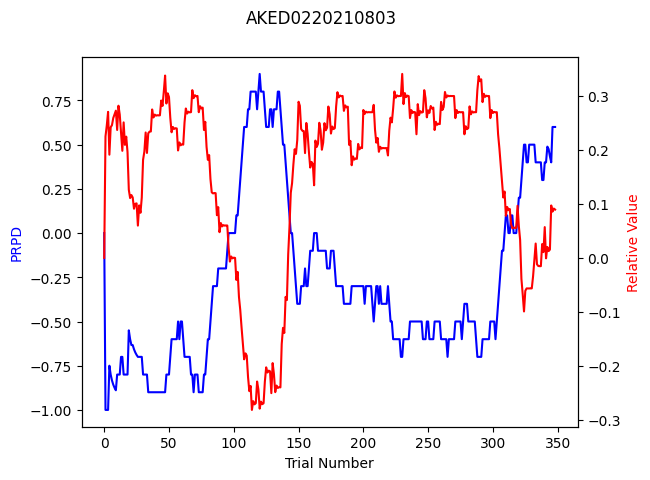

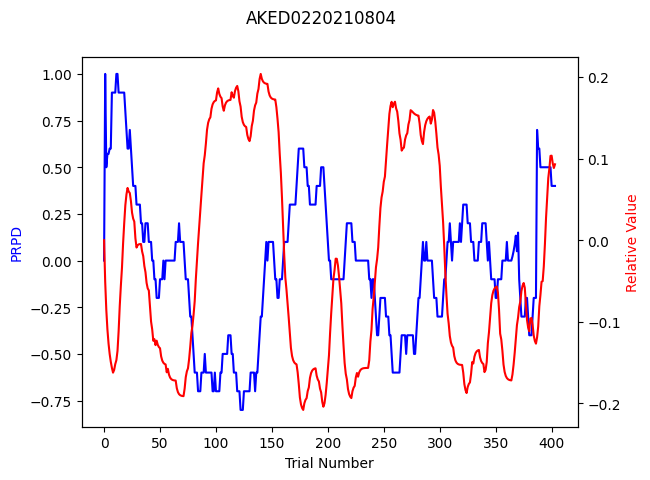

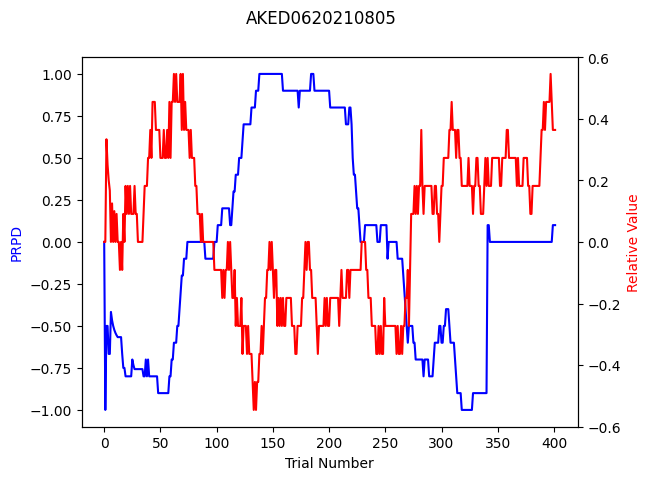

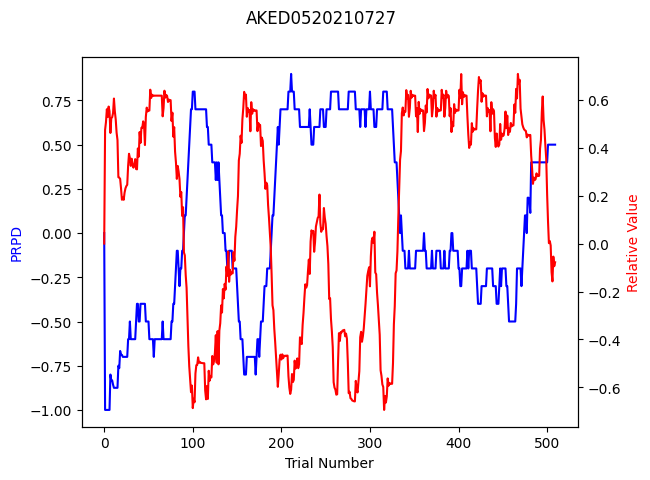

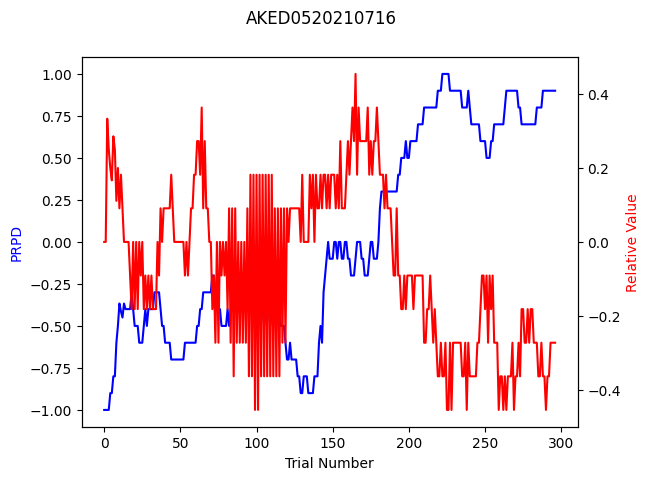

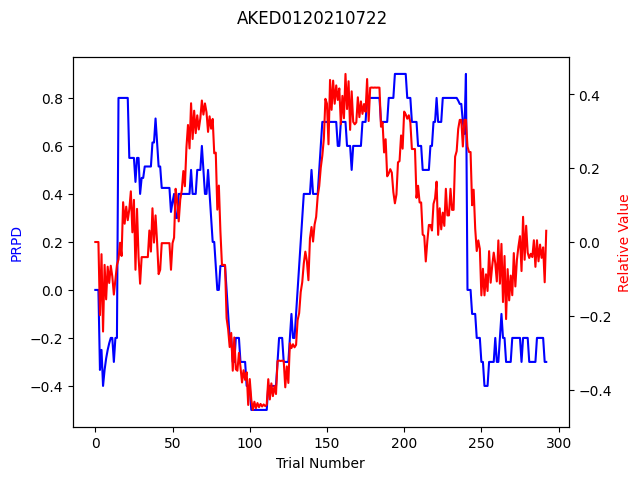

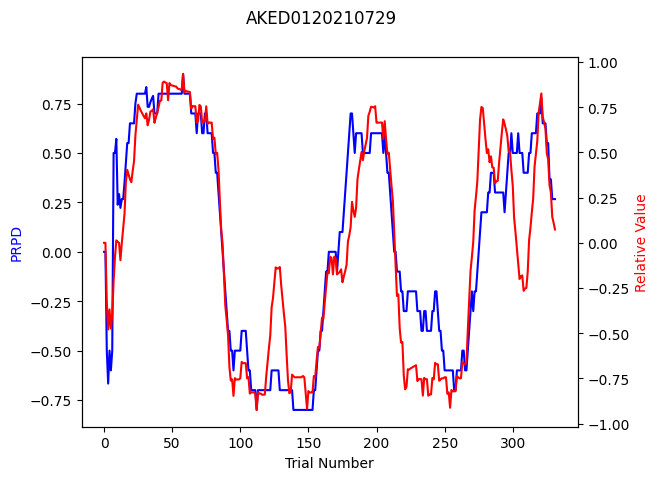

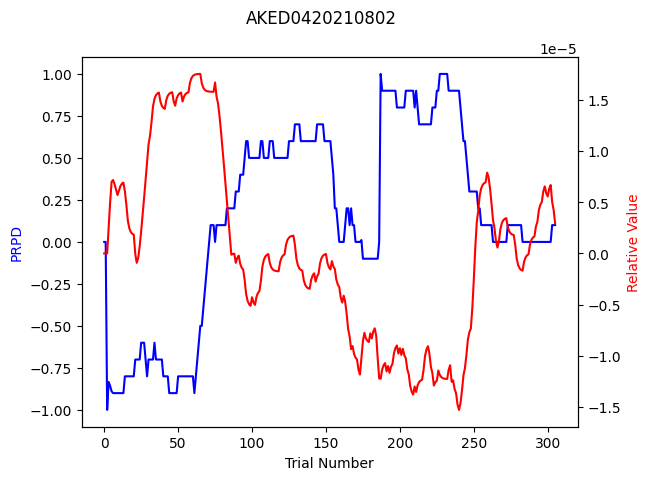

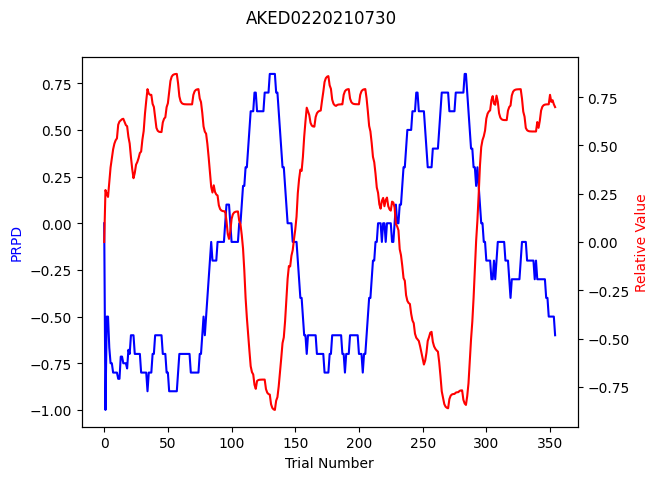

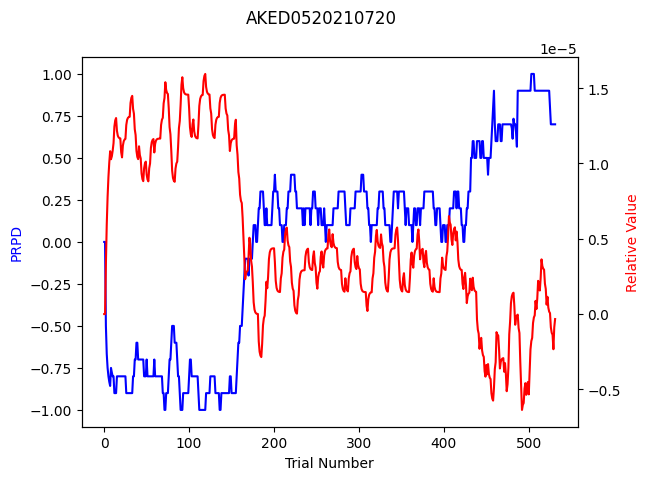

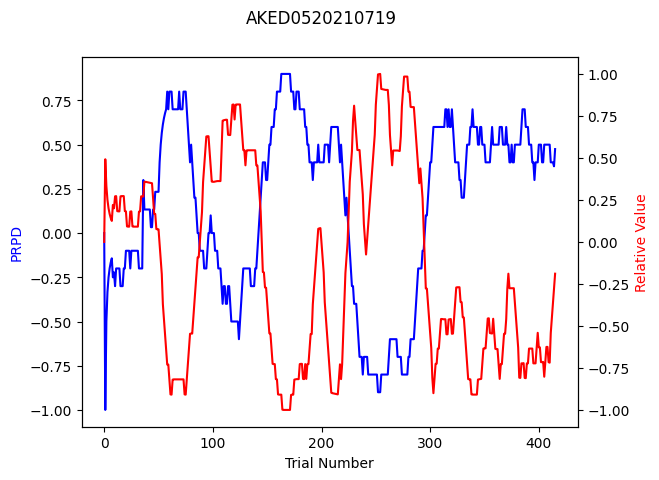

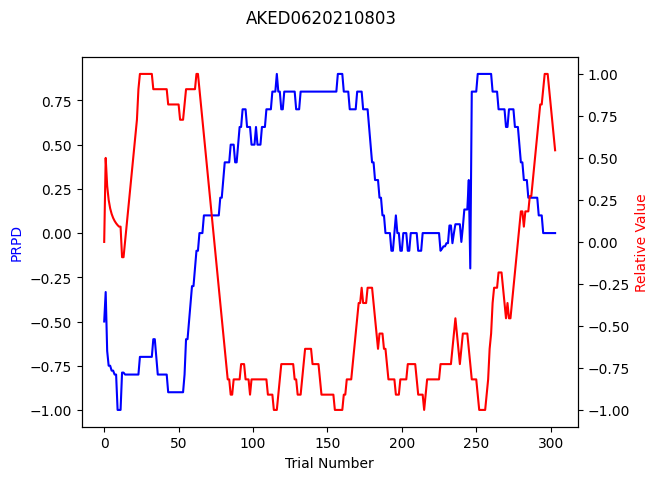

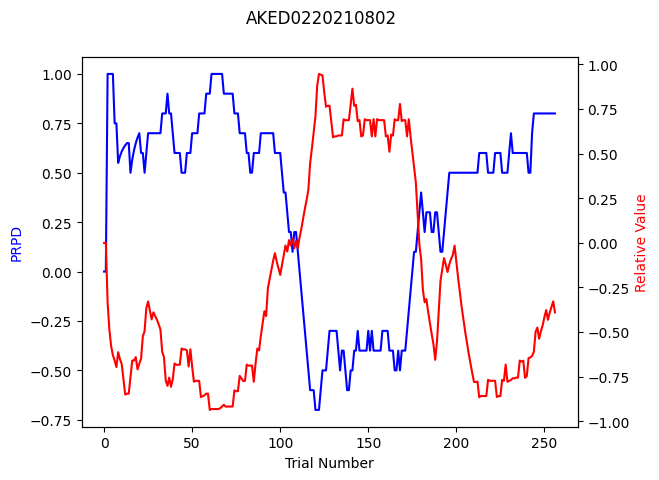

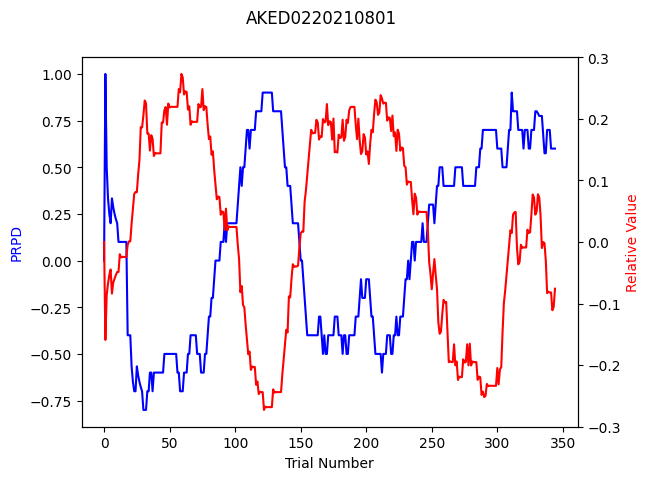

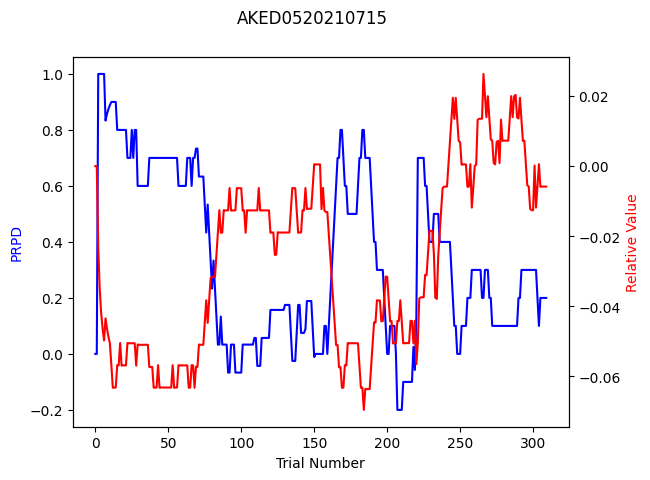

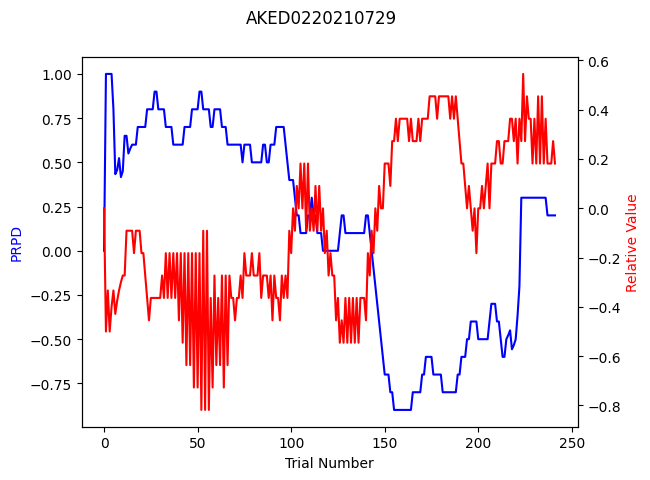

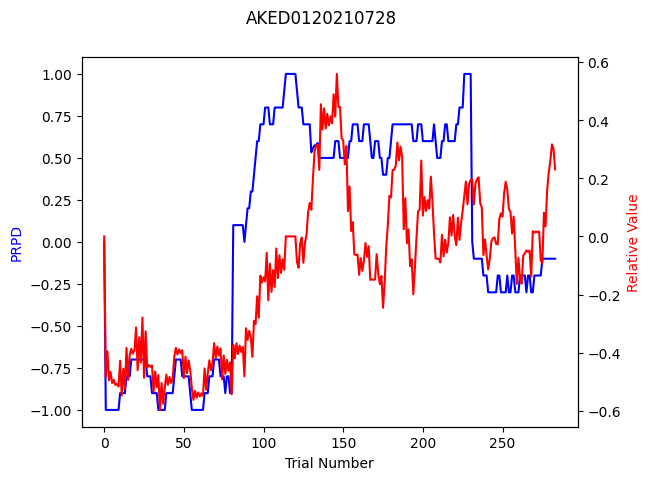

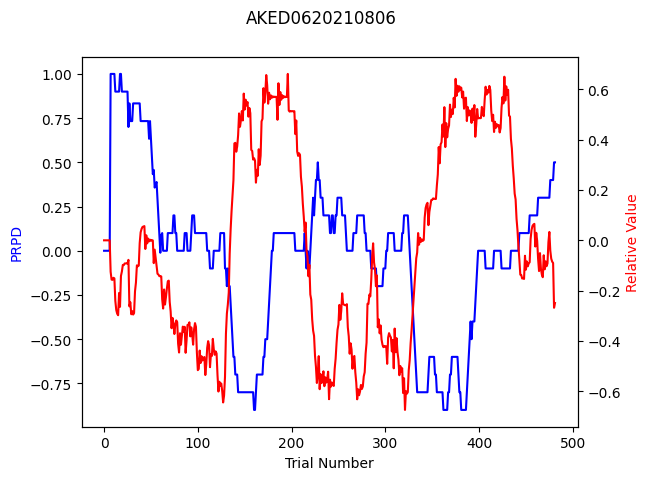

In [2]:
# for each session, load the relative value and the PRPD
# plot the PRPD against the relative value

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir

from lib.calculation import moving_window_mean_prior

for session in glob(pjoin('data', 'relative_values', '*.npy')):
    session = basename(session)
    session_name = session.split('.')[0]
    relative_value_path = pjoin('data', 'relative_values', session)
    relative_value = np.load(relative_value_path)
    # smoothen the relative value
    relative_value = moving_window_mean_prior(relative_value, 10)
    prpd_path = pjoin('data', 'prpd', session)
    prpd = np.load(prpd_path)
    # load the behaviour data and remove the nan trials in prpd
    behaviour_data = pd.read_csv(pjoin('data', 'behaviour_data', session_name + '.csv'))
    prpd = prpd[~np.isnan(behaviour_data['trial_reward'])]
    
    # plot PRPD and relative values as twin x line plot
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(prpd, color='blue')
    ax2.plot(relative_value, color='red')
    ax1.set_ylabel('PRPD', color='blue')
    ax2.set_ylabel('Relative Value', color='red')
    ax1.set_xlabel('Trial Number')
    fig.suptitle(session_name)
    plt.show()
    plt.close()

# Panel E

100%|██████████| 29/29 [00:08<00:00,  3.42it/s]


PFC response: 2.890022225585314
PFC bg: 2.8642000529568152
DMS response: -1.9926420028207914
DMS bg: -2.232600428450056
PFC response: 1183 / 1668
PFC bg: 1184 / 1668
DMS response: 740 / 974
DMS bg: 716 / 974


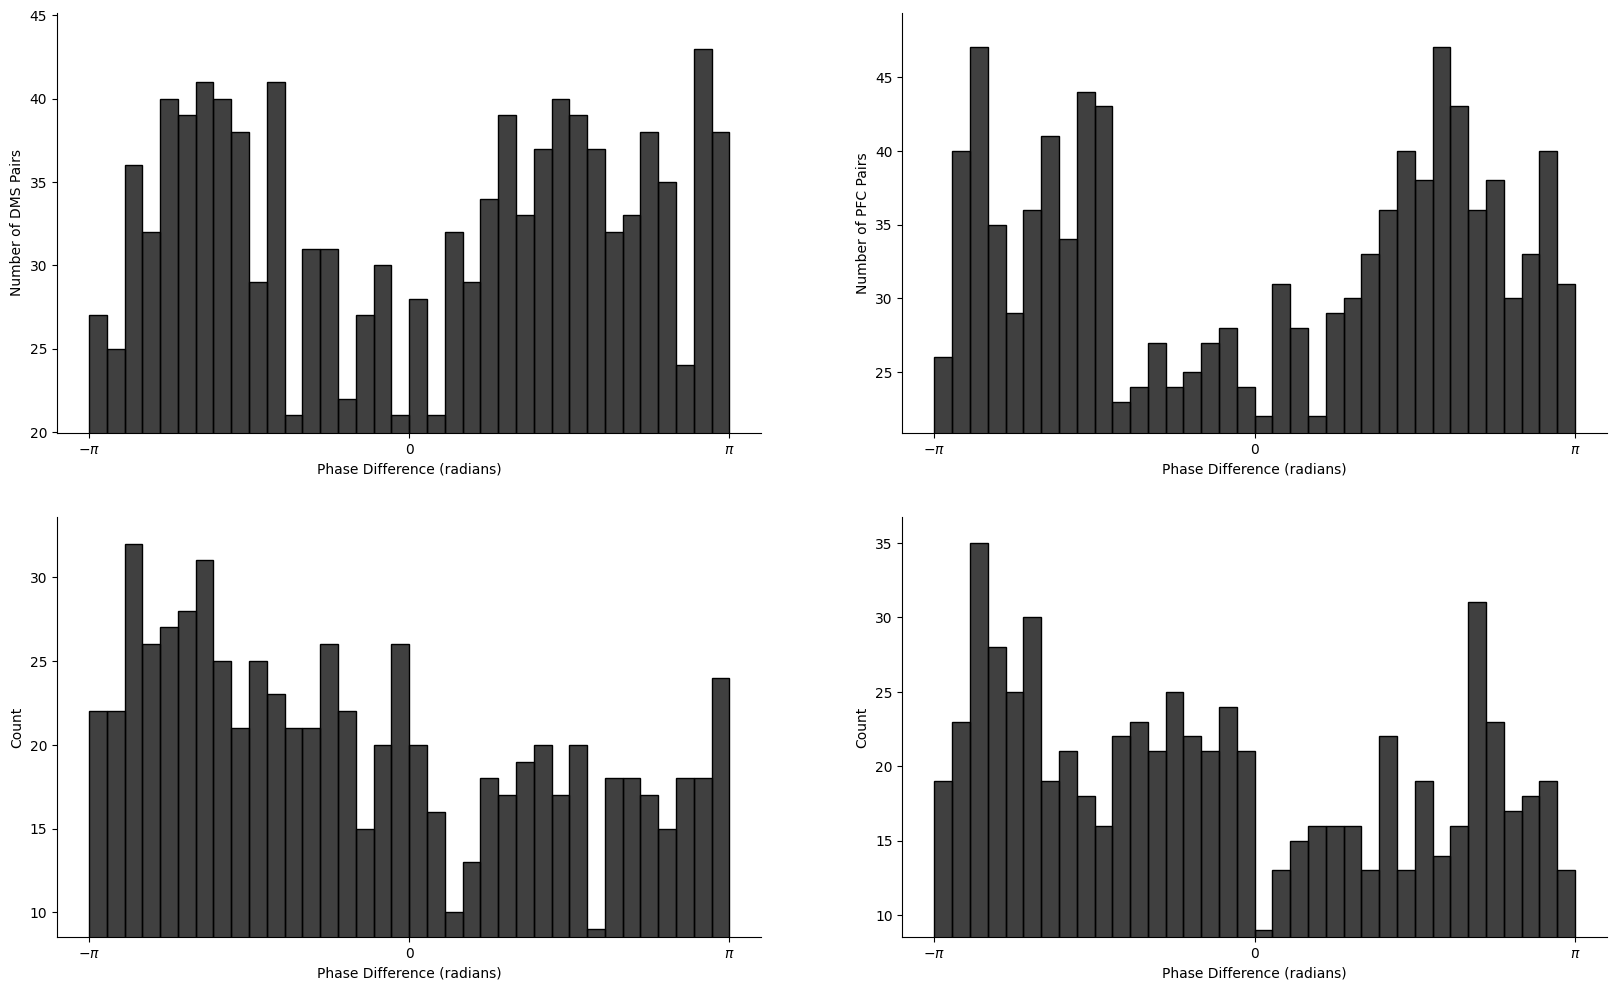

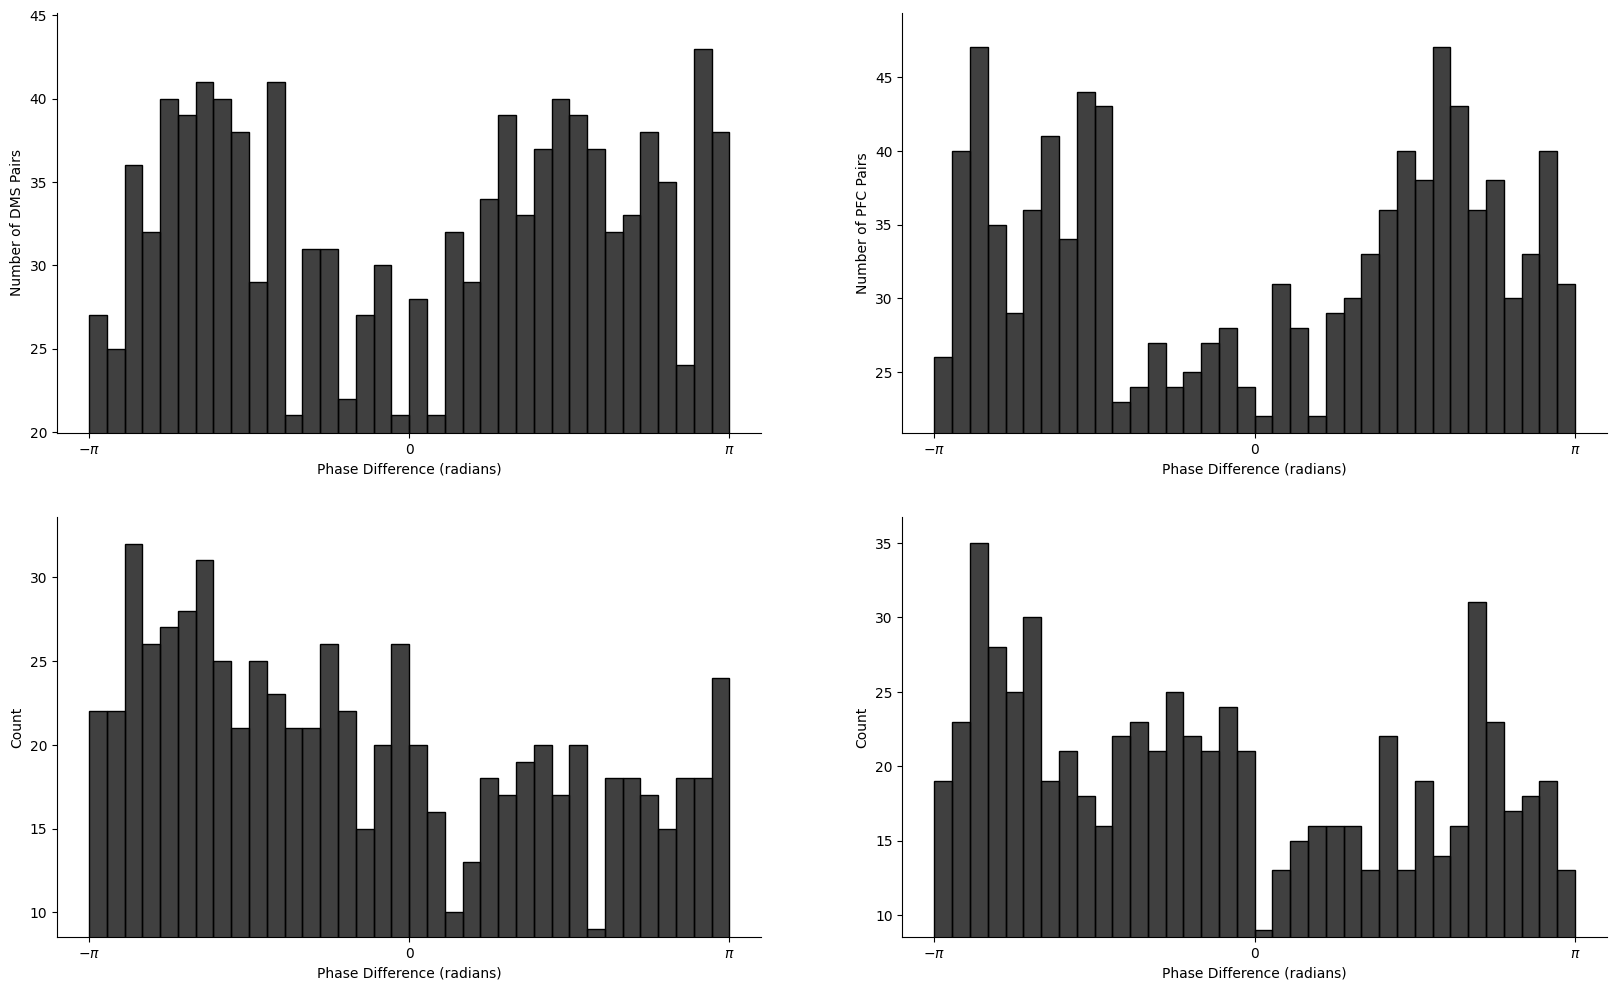

In [1]:
from lib.figure_5 import get_figure_5_panel_e

get_figure_5_panel_e(mono=False, no_nan=True, zero_ymin=False)

590it [01:05,  9.04it/s]


PFC response: -2.62120477355499
PFC bg: -2.718008847856746
DMS response: -1.7359451165669475
DMS bg: -1.382319383150432
PFC response: 420 / 590
PFC bg: 442 / 590
DMS response: 460 / 590
DMS bg: 429 / 590


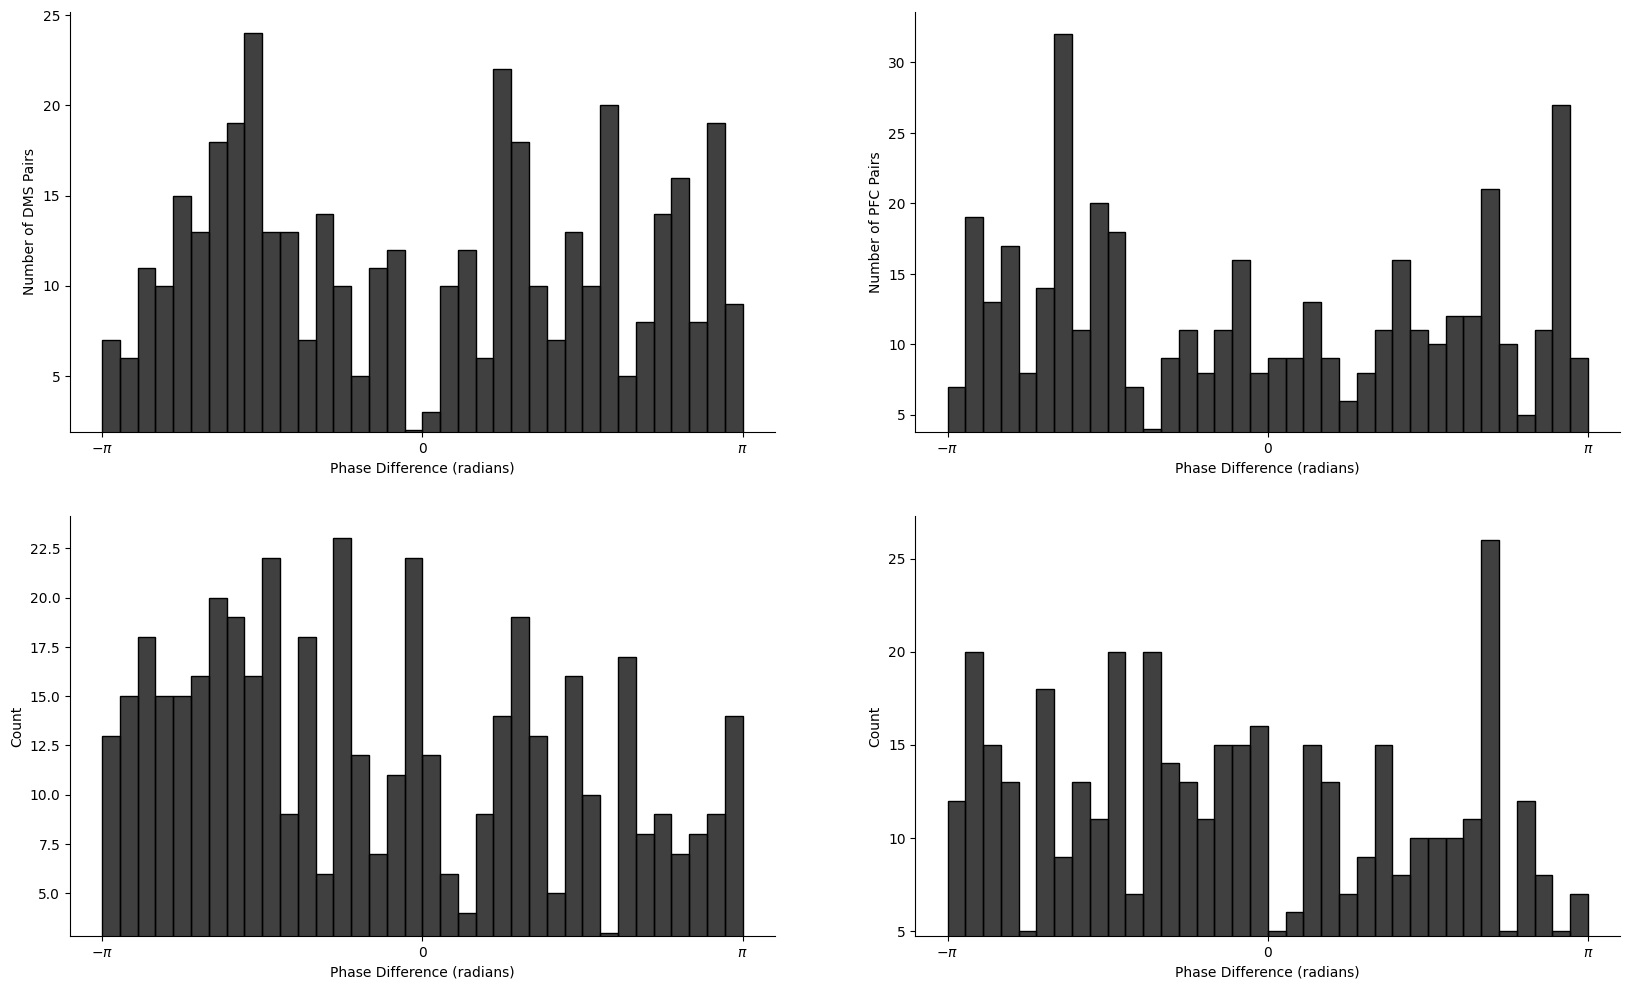

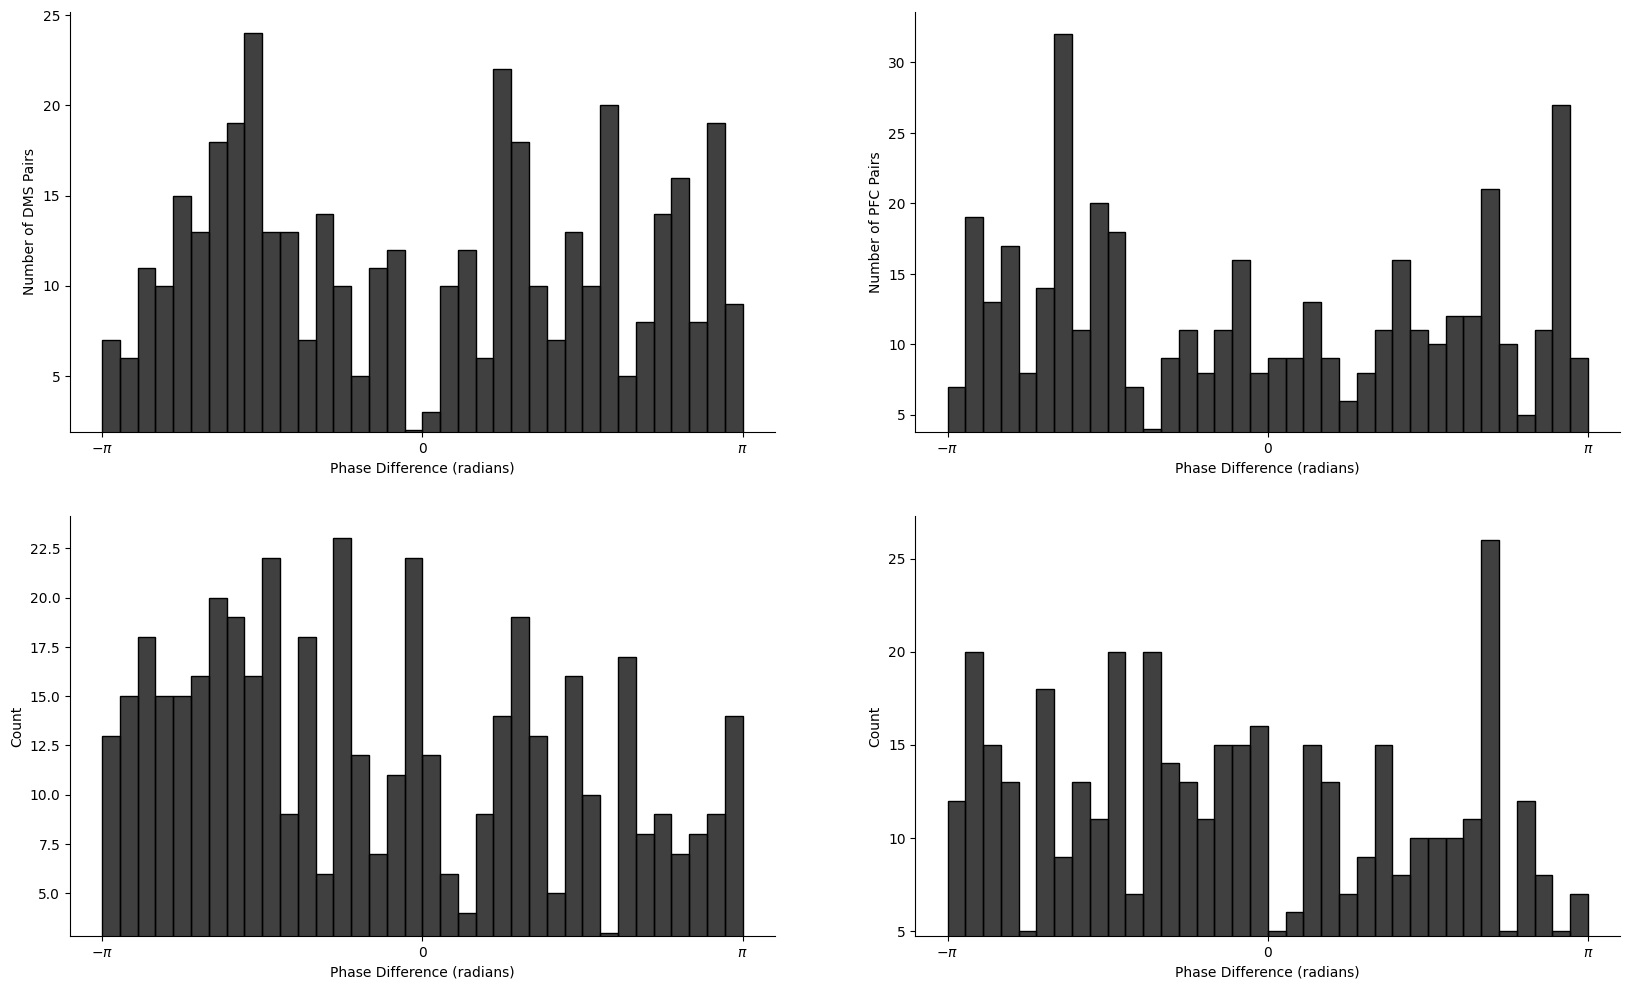

In [2]:
from lib.figure_5 import get_figure_5_panel_e

get_figure_5_panel_e(mono=True, no_nan=True, zero_ymin=False)